In [ ]:
! pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
! mkdir ~/.kaggle

In [ ]:
! cp kaggle.json ~/.kaggle/

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets download ananthu017/emotion-detection-fer

 89% 58.0M/65.2M [00:01<00:00, 45.9MB/s]
100% 65.2M/65.2M [00:01<00:00, 56.0MB/s]


In [ ]:
! unzip emotion-detection-fer

Streaming output truncated to the last 5000 lines.
  inflating: train/sad/im37.png      
  inflating: train/sad/im370.png     
  inflating: train/sad/im3700.png    
  inflating: train/sad/im3701.png    
  inflating: train/sad/im3702.png    
  inflating: train/sad/im3703.png    
  inflating: train/sad/im3704.png    
  inflating: train/sad/im3705.png    
  inflating: train/sad/im3706.png    
  inflating: train/sad/im3707.png    
  inflating: train/sad/im3708.png    
  inflating: train/sad/im3709.png    
  inflating: train/sad/im371.png     
  inflating: train/sad/im3710.png    
  inflating: train/sad/im3711.png    
  inflating: train/sad/im3712.png    
  inflating: train/sad/im3713.png    
  inflating: train/sad/im3714.png    
  inflating: train/sad/im3715.png    
  inflating: train/sad/im3716.png    
  inflating: train/sad/im3717.png    
  inflating: train/sad/im3718.png    
  inflating: train/sad/im3719.png    
  inflating: train/sad/im372.png     
  inflating: train/sad/im3720.png    

In [ ]:
import os
import cv2
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import cv2 as cv
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import keras
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten, Dropout, BatchNormalization, Activation
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, recall_score, precision_score, f1_score

In [ ]:
test_dir = '/content/test'
train_dir = '/content/train'
classes = ['angry', 'disgusted', 'fearful', 'happy', 'neutral', 'sad', 'surprised']

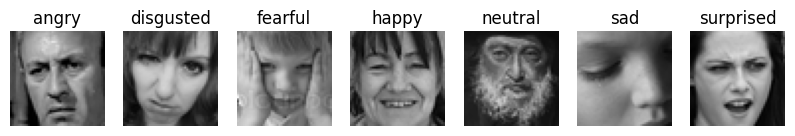

In [ ]:
index = 1
plt.figure(figsize=(10, 5))
for classname in classes:
    class_dir = os.path.join(train_dir, classname)
    
    for filename in os.listdir(class_dir)[:1]:
        image = cv.imread(os.path.join(class_dir, filename))
        
        plt.subplot(1, len(classes), index)
        plt.title(classname)
        plt.imshow(image, cmap="gray")
        plt.axis("off")
        
        index += 1
        
plt.show()

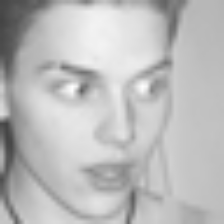

In [ ]:
images = []
image_classes = []
total_image_per_class = []

for classname in os.listdir(train_dir):
    class_dir = os.path.join(train_dir, classname)
    
    for filename in os.listdir(class_dir):
        image = cv.imread(os.path.join(class_dir, filename))
        image = cv.resize(image, (224, 224))
        image = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
        images.append(image)
        image_classes.append(classname)
        
    total_image_per_class.append(len(os.listdir(class_dir)))
        
data = list(zip(images, image_classes))
len(data)
from google.colab.patches import cv2_imshow
cv2_imshow(image)

In [ ]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True,
                                   validation_split=.2)

test_datagen = ImageDataGenerator(rescale = 1./255,
                                  shear_range = 0.2,
                                  zoom_range = 0.2,
                                  horizontal_flip = True)

In [ ]:
training_data = train_datagen.flow_from_directory(train_dir,
                                                  target_size=(224,224),
                                                  shuffle=True,
                                                  class_mode='categorical',
                                                  color_mode='rgb',
                                                  subset='training',
                                                  seed=10)

validation_data = train_datagen.flow_from_directory(train_dir,
                                                    target_size=(224, 224),
                                                    shuffle=False,
                                                    class_mode='categorical',
                                                    color_mode='rgb',
                                                    subset='validation',
                                                    seed=10)

testing_data = test_datagen.flow_from_directory(test_dir,
                                                target_size=(224, 224),
                                                shuffle=False,
                                                class_mode='categorical',
                                                color_mode='rgb',
                                                # subset='training',
                                                seed=10)

Found 22968 images belonging to 7 classes.
Found 5741 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [ ]:
rn50 = ResNet50(input_shape=[224, 224] + [3], weights='imagenet', include_top=False)

94765736/94765736 [==============================] - 1s 0us/step


In [ ]:
headModel = rn50.output
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(512, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(len(classes), activation="softmax")(headModel)

In [ ]:
model = Model(inputs=rn50.input, outputs=headModel)

In [ ]:
for layer in rn50.layers:
  layer.trainable = False

In [ ]:
# compile model
opt = SGD(learning_rate=1e-4, momentum=0.9)
model.compile(loss="categorical_crossentropy", optimizer=opt,
	metrics=["accuracy"])

In [ ]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',
                                            patience=3,
                                            mode='auto',
                                            baseline=None,
                                            restore_best_weights=False)

history = model.fit(training_data,
                    epochs=20,
                    validation_data=validation_data,
                    callbacks=[callback])

Epoch 1/20
718/718 [==============================] - 343s 459ms/step - loss: 1.8557 - accuracy: 0.2368 - val_loss: 1.8122 - val_accuracy: 0.2513
Epoch 2/20
718/718 [==============================] - 327s 455ms/step - loss: 1.8310 - accuracy: 0.2509 - val_loss: 1.8102 - val_accuracy: 0.2513
Epoch 3/20
718/718 [==============================] - 328s 457ms/step - loss: 1.8303 - accuracy: 0.2506 - val_loss: 1.8102 - val_accuracy: 0.2513
Epoch 4/20
718/718 [==============================] - 327s 455ms/step - loss: 1.8301 - accuracy: 0.2512 - val_loss: 1.8109 - val_accuracy: 0.2513


In [ ]:
def visualize_history(history):
    loss = history.history['loss']
    accuracy = history.history['accuracy']
    val_loss = history.history['val_loss']
    val_accuracy = history.history['val_accuracy']
    epochs = range(len(accuracy))

    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    plt.title("Training & Validation Accuracy")
    plt.plot(epochs, accuracy, label="accuracy")
    plt.plot(epochs, val_accuracy, label="val_accuracy")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.title("Training & Validation Loss")
    plt.plot(epochs, loss, label="loss")
    plt.plot(epochs, val_loss, label="val_loss")
    plt.legend()

    plt.show()

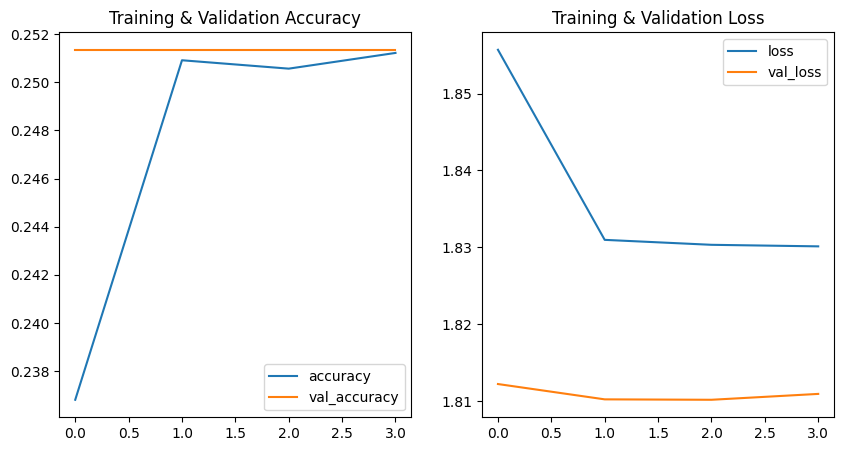

In [ ]:
visualize_history(history)

In [ ]:
model.evaluate(testing_data)

225/225 [==============================] - 82s 362ms/step - loss: 1.8148 - accuracy: 0.2471


[1.8147563934326172, 0.24714405834674835]

In [ ]:
y_pred = model.predict(testing_data)
y_pred_labels = []
for i in y_pred:
    y_pred_labels.append(np.argmax(i))
y_actual = testing_data.classes[testing_data.index_array]

225/225 [==============================] - 83s 362ms/step


In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_actual, y_pred_labels))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       958
           1       0.00      0.00      0.00       111
           2       0.00      0.00      0.00      1024
           3       0.25      1.00      0.40      1774
           4       0.00      0.00      0.00      1233
           5       0.00      0.00      0.00      1247
           6       0.00      0.00      0.00       831

    accuracy                           0.25      7178
   macro avg       0.04      0.14      0.06      7178
weighted avg       0.06      0.25      0.10      7178



/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score

acc = accuracy_score(y_actual, y_pred_labels)
prec = precision_score(y_actual, y_pred_labels, average='weighted')
rec = recall_score(y_actual, y_pred_labels, average='weighted')
f1 = f1_score(y_actual, y_pred_labels, average='weighted')

print("accuracy: ", acc)
print("recall: ", rec)
print("precision: ", prec)
print("f1-score: ", f1)
print("Result = ", (acc+rec+prec+f1)/4)

accuracy:  0.24714405126776262
recall:  0.24714405126776262
precision:  0.06108018207704248
f1-score:  0.09795208823704445
Result =  0.16333009321240305


/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
for layer in rn50.layers:
	layer.trainable = True

In [ ]:
for layer in rn50.layers:
	print("{}: {}".format(layer, layer.trainable))

<keras.engine.input_layer.InputLayer object at 0x7f20c8f61550>: True
<keras.layers.reshaping.zero_padding2d.ZeroPadding2D object at 0x7f20c8f75d00>: True
<keras.layers.convolutional.conv2d.Conv2D object at 0x7f20cbd5ac70>: True
<keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7f20c772be50>: True
<keras.layers.core.activation.Activation object at 0x7f20c772ba60>: True
<keras.layers.reshaping.zero_padding2d.ZeroPadding2D object at 0x7f20c5c2c9a0>: True
<keras.layers.pooling.max_pooling2d.MaxPooling2D object at 0x7f20c5c30490>: True
<keras.layers.convolutional.conv2d.Conv2D object at 0x7f20c5c33130>: True
<keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7f20c5c33430>: True
<keras.layers.core.activation.Activation object at 0x7f20c5c2c250>: True
<keras.layers.convolutional.conv2d.Conv2D object at 0x7f20c5c44670>: True
<keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7f20c5ee1550>: True
<keras.layers.c

In [ ]:
# recompile model
opt = SGD(learning_rate=1e-4, momentum=0.9)
model.compile(loss="categorical_crossentropy", optimizer=opt,
	metrics=["accuracy"])

In [ ]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',
                                            patience=3,
                                            mode='auto',
                                            baseline=None,
                                            restore_best_weights=False)

history = model.fit(training_data,
                    epochs=20,
                    validation_data=validation_data,
                    callbacks=[callback])

Epoch 1/20
718/718 [==============================] - 432s 574ms/step - loss: 1.6606 - accuracy: 0.3858 - val_loss: 1.9666 - val_accuracy: 0.2188
Epoch 2/20
718/718 [==============================] - 393s 547ms/step - loss: 1.3453 - accuracy: 0.4848 - val_loss: 1.2676 - val_accuracy: 0.5107
Epoch 3/20
718/718 [==============================] - 393s 548ms/step - loss: 1.2348 - accuracy: 0.5330 - val_loss: 1.2183 - val_accuracy: 0.5311
Epoch 4/20
718/718 [==============================] - 393s 547ms/step - loss: 1.1649 - accuracy: 0.5596 - val_loss: 1.1509 - val_accuracy: 0.5597
Epoch 5/20
718/718 [==============================] - 391s 545ms/step - loss: 1.0958 - accuracy: 0.5851 - val_loss: 1.1190 - val_accuracy: 0.5793
Epoch 6/20
718/718 [==============================] - 391s 544ms/step - loss: 1.0518 - accuracy: 0.6017 - val_loss: 1.0956 - val_accuracy: 0.5921
Epoch 7/20
718/718 [==============================] - 394s 548ms/step - loss: 1.0057 - accuracy: 0.6188 - val_loss: 1.0532 -

In [ ]:
def visualize_history(history):
    loss = history.history['loss']
    accuracy = history.history['accuracy']
    val_loss = history.history['val_loss']
    val_accuracy = history.history['val_accuracy']
    epochs = range(len(accuracy))

    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    plt.title("Training & Validation Accuracy")
    plt.plot(epochs, accuracy, label="accuracy")
    plt.plot(epochs, val_accuracy, label="val_accuracy")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.title("Training & Validation Loss")
    plt.plot(epochs, loss, label="loss")
    plt.plot(epochs, val_loss, label="val_loss")
    plt.legend()

    plt.show()

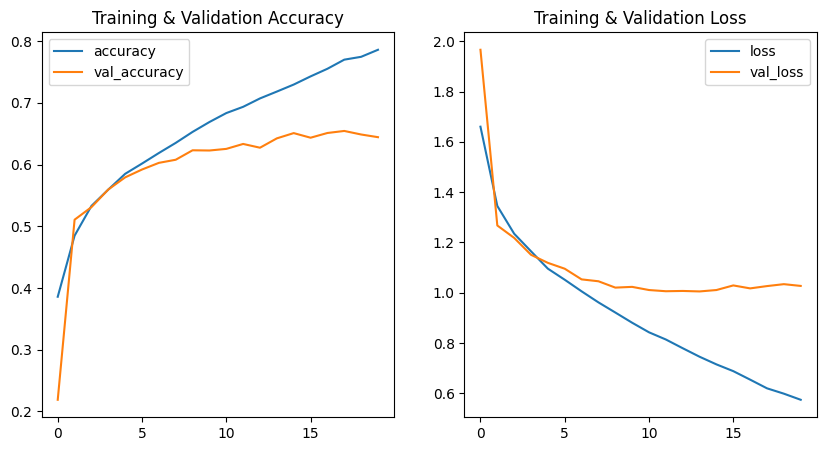

In [ ]:
visualize_history(history)

In [ ]:
model.evaluate(testing_data)

225/225 [==============================] - 81s 360ms/step - loss: 1.0350 - accuracy: 0.6489


[1.0350160598754883, 0.6489272713661194]

In [ ]:
y_pred = model.predict(testing_data)
y_pred_labels = []
for i in y_pred:
    y_pred_labels.append(np.argmax(i))
y_actual = testing_data.classes[testing_data.index_array]

225/225 [==============================] - 81s 358ms/step


In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_actual, y_pred_labels))

              precision    recall  f1-score   support

           0       0.54      0.57      0.56       958
           1       0.75      0.47      0.58       111
           2       0.48      0.47      0.48      1024
           3       0.85      0.84      0.85      1774
           4       0.61      0.65      0.63      1233
           5       0.54      0.50      0.51      1247
           6       0.77      0.79      0.78       831

    accuracy                           0.65      7178
   macro avg       0.65      0.61      0.63      7178
weighted avg       0.65      0.65      0.65      7178



In [ ]:
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score

acc = accuracy_score(y_actual, y_pred_labels)
prec = precision_score(y_actual, y_pred_labels, average='weighted')
rec = recall_score(y_actual, y_pred_labels, average='weighted')
f1 = f1_score(y_actual, y_pred_labels, average='weighted')

print("accuracy: ", acc)
print("recall: ", rec)
print("precision: ", prec)
print("f1-score: ", f1)
print("Result = ", (acc+rec+prec+f1)/4)

accuracy:  0.6489272777932572
recall:  0.6489272777932572
precision:  0.6493882305724921
f1-score:  0.6483189101241063
Result =  0.6488904240707782
